<h1 style="text-align:center; background-color:#C8D741">Deep Learning Model for Performing Sentiment Analysis of Tweets from Joe Biden</h1>

In this notebook, I have tried to perform sentiment analysis on Joe Biden's tweets using a BERT-based model. This model is trained on ["First GOP Debate Twitter Sentiment"](https://www.kaggle.com/crowdflower/first-gop-debate-twitter-sentiment). After which, the trained model is used to classify Joe Biden's tweets into three categories : *positive, negative and neutral*. The rest of the notebook is organized as follows :

1. Exploratory Data Analysis
    * Most common words employed in Joe Biden's tweets
    * Twitter word cloud of most commons terms
    * Analyze how the frequency of *likes, retweets, replies and quotes* vary with time.

2. Sentiment Analysis on Tweets
    * Importing libraries
    * Loading BERT model and BERT tokenizer
    * Sample tweets
    * Creating data loaders
    * Sentiment classifier model
    * Mode training
    * Results and evaluations
  
3. Final dataset that contains sentiment classification of Joe Biden's tweets.
4. Word clouds for positive, negative and neutral tweets from Joe Biden.
5. Future work
6. References

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/first-gop-debate-twitter-sentiment/database.sqlite
/kaggle/input/first-gop-debate-twitter-sentiment/Sentiment.csv
/kaggle/input/joe-biden-tweets/JoeBidenTweets.csv
/kaggle/input/bert-base-uncased/vocab.txt
/kaggle/input/bert-base-uncased/config.json
/kaggle/input/bert-base-uncased/pytorch_model.bin


In [2]:
df = pd.read_csv('/kaggle/input/joe-biden-tweets/JoeBidenTweets.csv')
df.head()

,id,timestamp,url,tweet,replies,retweets,quotes,likes
0,1320716067111653378,2020-10-26 13:17,https://twitter.com/JoeBiden/status/1320716067...,This is the most important election of our lif...,1688,2783,289,20898
1,1320516150988451841,2020-10-26 00:02,https://twitter.com/JoeBiden/status/1320516150...,"Folks, the I Will Vote concert is finally here...",4497,3686,489,18406
2,1320507935756328960,2020-10-25 23:30,https://twitter.com/JoeBiden/status/1320507935...,It's clear Donald Trump will stop at nothing t...,4474,6540,738,34027
3,1320500637352693761,2020-10-25 23:01,https://twitter.com/JoeBiden/status/1320500637...,I will never give up on the American people. h...,3706,12398,1425,56596
4,1320485537782878208,2020-10-25 22:01,https://twitter.com/JoeBiden/status/1320485537...,Jacquelyn — I was honored to meet you in Decem...,2108,4218,520,29385


<h1 style="text-align:center; background-color:#D8E46B">Exploratory Data Analysis</h1>

In [3]:
import nltk
import re
import string
from string import punctuation
from nltk.corpus import stopwords

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)

    return text


def punctuation_stopwords_removal(git_text):
    remove_punctuation = [ch for ch in git_text if ch not in punctuation]
    # convert them back to sentences and split into words
    remove_punctuation = "".join(remove_punctuation).split()
    filtered_git_text = [word.lower() for word in remove_punctuation if word.lower() not in stopwords.words('english')]
    return filtered_git_text

In [4]:
df['tweet'] = df['tweet'].apply(lambda x: clean_text(x))
df['tweet'] = df['tweet'].apply(punctuation_stopwords_removal)
df.head()

,id,timestamp,url,tweet,replies,retweets,quotes,likes
0,1320716067111653378,2020-10-26 13:17,https://twitter.com/JoeBiden/status/1320716067...,"[important, election, lifetimes, dont, wait, m...",1688,2783,289,20898
1,1320516150988451841,2020-10-26 00:02,https://twitter.com/JoeBiden/status/1320516150...,"[folks, vote, concert, finally, tune, incredib...",4497,3686,489,18406
2,1320507935756328960,2020-10-25 23:30,https://twitter.com/JoeBiden/status/1320507935...,"[clear, donald, trump, stop, nothing, tear, ob...",4474,6540,738,34027
3,1320500637352693761,2020-10-25 23:01,https://twitter.com/JoeBiden/status/1320500637...,"[never, give, american, people]",3706,12398,1425,56596
4,1320485537782878208,2020-10-25 22:01,https://twitter.com/JoeBiden/status/1320485537...,"[jacquelyn, —, honored, meet, december, i’m, h...",2108,4218,520,29385


In [5]:
# removing optional columns
df.drop(['id', 'url'], axis=1, inplace=True)

In [6]:
import plotly.express as px
from collections import Counter

def plot_most_common_terms(df):
    word_list = []
    
    for i, j in df.iterrows():
        for word in j['tweet']:
            word_list.append(word)
        
    count_dict = Counter(word_list)
    most_common_words_df = pd.DataFrame(count_dict.most_common(20), columns=['word', 'count'])
    
    fig = px.histogram(most_common_words_df,
                       x='word', 
                       y='count',
                       title='Most common terms used in Joe Biden\'s tweets.',
                       color_discrete_sequence=['#D8E46B'] )
    fig.show()

In [7]:
plot_most_common_terms(df)

In [8]:
import cv2
import urllib
import matplotlib.pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator

def load_mask(mask_url):
    with urllib.request.urlopen(mask_url) as resp:
        mask = np.asarray(bytearray(resp.read()), dtype="uint8")
        mask = cv2.imdecode(mask, cv2.IMREAD_COLOR)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        
    return mask

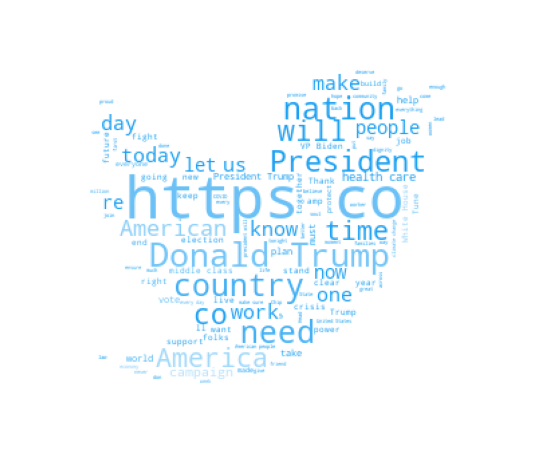

In [9]:
new_mask = load_mask('https://www.creativefreedom.co.uk/wp-content/uploads/2017/06/Twitter-featured.png')

wordcloud = WordCloud(
    background_color="white",
    mask=new_mask,
    random_state=42,
    max_font_size=50,
    max_words=1000,
)

df_tweet = pd.read_csv('/kaggle/input/joe-biden-tweets/JoeBidenTweets.csv')
text = ''.join(df_tweet['tweet'].values)


wordcloud.generate(text) 

image_colors = ImageColorGenerator(new_mask)

plt.figure(figsize=(16, 8))
plt.imshow(wordcloud.recolor(color_func=image_colors))
plt.axis("off")
plt.show()

In [10]:
import datetime

df['timestamp'] = df['timestamp'].apply(lambda x : datetime.datetime.strptime(x.split(" ")[0], "%Y-%m-%d"))
df.head()

,timestamp,tweet,replies,retweets,quotes,likes
0,2020-10-26,"[important, election, lifetimes, dont, wait, m...",1688,2783,289,20898
1,2020-10-26,"[folks, vote, concert, finally, tune, incredib...",4497,3686,489,18406
2,2020-10-25,"[clear, donald, trump, stop, nothing, tear, ob...",4474,6540,738,34027
3,2020-10-25,"[never, give, american, people]",3706,12398,1425,56596
4,2020-10-25,"[jacquelyn, —, honored, meet, december, i’m, h...",2108,4218,520,29385


In [11]:
df_count = pd.DataFrame()

df_count['replies'] = df.groupby(['timestamp'])['replies'].sum()
df_count['retweets'] = df.groupby(['timestamp'])['retweets'].sum()
df_count['quotes'] = df.groupby(['timestamp'])['quotes'].sum()
df_count['likes'] = df.groupby(['timestamp'])['likes'].sum()
df_final = df_count.reset_index()
df_count.head()

,replies,retweets,quotes,likes
timestamp,,,,
2007-10-24,19,6,18,12
2007-12-29,13,16,6,22
2012-04-09,318,763,38,145
2012-04-10,71,308,1,152
2012-04-11,79,555,0,233


In [12]:
import plotly.graph_objects as go

def plot_frequency_of_tweet_properties(df):
    # Create traces
    fig = go.Figure()
    
    fig.add_trace(go.Scatter(x=df['timestamp'], y=df['replies'],
                        mode='lines',
                        name='Replies'))
    
    fig.add_trace(go.Scatter(x=df['timestamp'], y=df['retweets'],
                        mode='lines',
                        name='Re-tweets'))
    
    fig.add_trace(go.Scatter(x=df['timestamp'], y=df['quotes'],
                        mode='lines',
                        name='Quotes'))
    
    fig.add_trace(go.Scatter(x=df['timestamp'], y=df['likes'],
                        mode='lines',
                        name='Likes'))

    fig.show()

In [13]:
plot_frequency_of_tweet_properties(df_final)

<h1 style="text-align:center; background-color:#D8E46B">Sentiment Analysis on Tweets</h1>

In order to classify tweets from Joe Biden, I would be leveraging a BERT based model. In order to train the model, I will be using [First GOP Debate Twitter Sentiment](https://www.kaggle.com/crowdflower/first-gop-debate-twitter-sentiment) which contains sentiment value (positive, negative and neutral) as well s the tweet.

In [14]:
df_debate_tweets = pd.read_csv('/kaggle/input/first-gop-debate-twitter-sentiment/Sentiment.csv')
df_debate = pd.DataFrame()
df_debate['tweet'] = df_debate_tweets['text']
df_debate['sentiment'] = df_debate_tweets['sentiment']

df_debate['tweet'] = df_debate['tweet'].apply(lambda x: clean_text(x))
df_debate['tweet'] = df_debate['tweet'].apply(lambda x: x.replace("rt", ""))

df_debate.head()

,tweet,sentiment
0,nancyleegrahn how did everyone feel about the...,Neutral
1,scottwalker didnt catch the full gopdebate la...,Positive
2,tjmshow no mention of tamir rice and the gopd...,Neutral
3,robgeorge that carly fiorina is trending hou...,Positive
4,danscavino gopdebate w realdonaldtrump delive...,Positive


In [15]:
def encode_labels(df):
    for i, j in df_debate.iterrows():
        if j['sentiment']=='Negative':
            j['sentiment']=0
        elif j['sentiment']=='Positive':
            j['sentiment']=1
        elif j['sentiment']=='Neutral':
            j['sentiment']=2
            
    return df_debate

In [16]:
df_debate = encode_labels(df_debate)

In [17]:
df_debate.head()

,tweet,sentiment
0,nancyleegrahn how did everyone feel about the...,2
1,scottwalker didnt catch the full gopdebate la...,1
2,tjmshow no mention of tamir rice and the gopd...,2
3,robgeorge that carly fiorina is trending hou...,1
4,danscavino gopdebate w realdonaldtrump delive...,1


<h2 style="text-align:center; background-color:#D8E46B">Importing Libraries</h2>

In [18]:
import torch
import torch.nn as nn

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

<h2 style="text-align:center; background-color:#D8E46B">Loading BERT model and BERT tokenizer</h2>

In [20]:
#loading our BERT model
BERT_UNCASED = '/kaggle/input/bert-base-uncased'

In [21]:
#loading the pre-trained BertTokenizer
tokenizer = BertTokenizer.from_pretrained(BERT_UNCASED)

<h2 style="text-align:center; background-color:#D8E46B">Sample Tweet</h2>

In [22]:
# some basic operations to understand how BERT converts a sentence into tokens and then into IDs
sample_body = 'danscavino gopdebate w realdonaldtrump delivered the highest ratings in the history of presidential debates'
tokens = tokenizer.tokenize(sample_body)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_body}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: danscavino gopdebate w realdonaldtrump delivered the highest ratings in the history of presidential debates
   Tokens: ['dans', '##ca', '##vino', 'go', '##pd', '##eb', '##ate', 'w', 'real', '##don', '##ald', '##trum', '##p', 'delivered', 'the', 'highest', 'ratings', 'in', 'the', 'history', 'of', 'presidential', 'debates']
Token IDs: [18033, 3540, 26531, 2175, 17299, 15878, 3686, 1059, 2613, 5280, 19058, 24456, 2361, 5359, 1996, 3284, 8599, 1999, 1996, 2381, 1997, 4883, 14379]


In [23]:
# using encode_plus to add special tokens : [CLS]:101, [SEP]:102, [PAD]:0
encodings = tokenizer.encode_plus(
            sample_body,
            max_length=32,
            add_special_tokens=True,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt'
)

encodings.keys()

dict_keys(['input_ids', 'attention_mask'])

In [24]:
print('Input IDs : {}'.format(encodings['input_ids'][0]))
print('\nAttention Mask : {}'.format(encodings['attention_mask'][0]))

Input IDs : tensor([  101, 18033,  3540, 26531,  2175, 17299, 15878,  3686,  1059,  2613,
         5280, 19058, 24456,  2361,  5359,  1996,  3284,  8599,  1999,  1996,
         2381,  1997,  4883, 14379,   102,     0,     0,     0,     0,     0,
            0,     0])

Attention Mask : tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 0, 0, 0, 0, 0, 0])


<h2 style="text-align:center; background-color:#D8E46B">Class for tweets dataset</h2>

In [25]:
# setting maximum length of tweets
MAX_LENGTH = 150

In [26]:
class Tweets(Dataset):
    
    def __init__(self, tweet, label, tokenizer, max_len):
        self.tweet = tweet
        self.label = label
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.tweet)
    
    def __getitem__(self, item):
        tweet = str(self.tweet[item])
        label = self.label[item]
        
        encoding = self.tokenizer.encode_plus(
        tweet,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt')
        return {
        'tweet': tweet,
         'input_ids': encoding['input_ids'],
         'attention_mask': encoding['attention_mask'],
         'label': torch.tensor(label, dtype=torch.long)
          }

<h2 style="text-align:center; background-color:#D8E46B">Creating data loaders</h2>

In [27]:
from sklearn.model_selection import train_test_split

training_data, testing_data = train_test_split(
    df_debate,
    test_size=0.1,
    random_state=RANDOM_SEED
)

testing_data, validation_data = train_test_split(
    testing_data,
    test_size=0.5,
    random_state=RANDOM_SEED
)

In [28]:
training_data.head()

,tweet,sentiment
1512,kvxrdashian when you leave the republican pay...,2
5331,at gopdebate i won over our largest audience y...,2
3573,smethanie if women abo their rape babies the ...,0
6301,posting this at the risk of enflaming the situ...,0
13502,i really like ben carson so far hes been class...,1


In [29]:
def create_data_loader(data, tokenizer, max_len, batch_size):
    
    ds = Tweets(tweet=data.tweet.to_numpy(),
    label=data.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len)
    
    return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4)


BATCH_SIZE = 64
train_data_loader = create_data_loader(training_data, tokenizer, MAX_LENGTH, BATCH_SIZE)
testing_data_loader = create_data_loader(testing_data, tokenizer, MAX_LENGTH, BATCH_SIZE)
val_data_loader = create_data_loader(validation_data, tokenizer, MAX_LENGTH, BATCH_SIZE)

In [30]:
df = next(iter(train_data_loader))
df.keys()

dict_keys(['tweet', 'input_ids', 'attention_mask', 'label'])

In [31]:
df['input_ids'].squeeze().shape, df['attention_mask'].squeeze().shape, df['label'].shape

(torch.Size([64, 150]), torch.Size([64, 150]), torch.Size([64]))

In [32]:
print('tweet  : ', df['tweet'][0])
print('input_ids : ', df['input_ids'].squeeze()[0])
print('attention_mask : ', df['attention_mask'].squeeze()[0])
print('label : ', df['label'][0])

tweet  :   kvxrdashian when you leave the republican pay and become a democrat gopdebate 
input_ids :  tensor([  101, 24888,  2595, 13639,  6182,  2319,  2043,  2017,  2681,  1996,
         3951,  3477,  1998,  2468,  1037,  7672,  2175, 17299, 15878,  3686,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,    

In [33]:
bert_model = BertModel.from_pretrained(BERT_UNCASED)

In [34]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encodings['input_ids'],
  attention_mask=encodings['attention_mask']
)

In [35]:
last_hidden_state.shape, pooled_output.shape

(torch.Size([1, 32, 768]), torch.Size([1, 768]))

<h2 style="text-align:center; background-color:#D8E46B">Sentiment Classifier Model</h2>

In [36]:
class SentimentClassifier(nn.Module):
    
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert_model = BertModel.from_pretrained(BERT_UNCASED)
        self.dropout = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert_model.config.hidden_size, n_classes)
        
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert_model(
        input_ids=input_ids,
        attention_mask = attention_mask
        )
        output = self.dropout(pooled_output)
        return self.out(output)

In [37]:
"""
label 0: Negative
label 1: Positive
label 2: Neutral
"""
class_names = [0, 1, 2]
sentiment_classifier = SentimentClassifier(len(class_names))
sentiment_classifier = sentiment_classifier.to(device)

In [38]:
EPOCHS = 10

optimizer = AdamW(sentiment_classifier.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [39]:
def train_model(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    
    losses = []
    correct_predictions = 0
    
    for d in data_loader:
        input_ids = d['input_ids'].squeeze().to(device)
        attention_mask = d['attention_mask'].squeeze().to(device)
        targets = d['label'].to(device)

        outputs = model(input_ids = input_ids, attention_mask = attention_mask)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        
        correct_predictions += torch.sum(preds==targets)
        losses.append(loss.item())
        
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    return correct_predictions.double()/n_examples, np.mean(losses)

In [40]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids'].squeeze().to(device)
            attention_mask = d['attention_mask'].squeeze().to(device)
            targets = d['label'].to(device)

            outputs = model(input_ids = input_ids, attention_mask = attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds==targets)
            losses.append(loss.item())
    
    return correct_predictions.double()/n_examples, np.mean(losses)

<h2 style="text-align:center; background-color:#D8E46B">Model training</h2>

In [41]:
%%time
from collections import defaultdict

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print('EPOCH {}/{}'.format(epoch+1,EPOCHS))
    print('-' * 10)
    
    train_acc, train_loss = train_model(sentiment_classifier, train_data_loader, loss_fn, optimizer, device, scheduler, len(training_data))
    
    print('Train loss : {} accuracy : {}'.format(train_loss, train_acc))
    
    val_acc, val_loss = eval_model(sentiment_classifier, val_data_loader, loss_fn, device, len(validation_data))
    
    print('Validation loss : {} accuracy : {}'.format(val_loss, val_acc))
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    if val_acc > best_accuracy:
        print('Saving the best model ...')
        torch.save(sentiment_classifier.state_dict(), 'best_model.bin')
        best_accuracy = val_acc
    

EPOCH 1/10
----------
Train loss : 0.7491550593047726 accuracy : 0.6781222462549066
Validation loss : 0.6864826110276309 accuracy : 0.7334293948126801
Saving the best model ...
EPOCH 2/10
----------
Train loss : 0.5369071016962431 accuracy : 0.779219738844829
Validation loss : 0.7045599628578533 accuracy : 0.7319884726224783
EPOCH 3/10
----------
Train loss : 0.39489175981784963 accuracy : 0.8453897300328446
Validation loss : 0.8325907750563188 accuracy : 0.7262247838616714
EPOCH 4/10
----------
Train loss : 0.3029810193847694 accuracy : 0.8832812625170231
Validation loss : 0.9066479910503734 accuracy : 0.7305475504322766
EPOCH 5/10
----------
Train loss : 0.25211554499371547 accuracy : 0.9037090443002482
Validation loss : 0.9264693449844014 accuracy : 0.7521613832853026
Saving the best model ...
EPOCH 6/10
----------
Train loss : 0.22037802303770596 accuracy : 0.9146038612513017
Validation loss : 0.9959113868800077 accuracy : 0.7363112391930835
EPOCH 7/10
----------
Train loss : 0.196

<h2 style="text-align:center; background-color:#D8E46B">Results and Evaluation</h2>

So our BERT model has achieved 93.7% accuracy on training dataset and 74.0% accuracy on validation dataset. This was achieved after training our BERT model on "GOP debate" dataset. Now, we will use this trained model to classify tweets from Joe Biden into 3 categories : *positive, negative and neutral*.

In [42]:
testing_data.shape

(694, 2)

In [43]:
def predict_sentiment_category(tweet, model):
    class_names = ['negative', 'positive', 'neutral']
    encoded_message = tokenizer.encode_plus(tweet, max_length=MAX_LENGTH, add_special_tokens=True, return_token_type_ids=False, pad_to_max_length=True, return_attention_mask=True, return_tensors='pt')
    input_ids = encoded_message['input_ids'].to(device)
    attention_mask = encoded_message['attention_mask'].to(device)
    
    output = model(input_ids=input_ids, attention_mask=attention_mask)
    _, prediction_idx = torch.max(output, dim=1)
        
    return (prediction_idx, class_names[prediction_idx])

In [44]:
tweet = testing_data['tweet'][3448]
print('Sample tweet from Joe Biden : ', tweet)
print('Predicted sentiment category : ', predict_sentiment_category(tweet, sentiment_classifier)[1])

Sample tweet from Joe Biden :    foxnews  after last nights gopdebate  realbencarson govmikehuckabee  have emerged as my top two
Predicted sentiment category :  positive


In [45]:
df = pd.read_csv('/kaggle/input/joe-biden-tweets/JoeBidenTweets.csv')
df.head()

,id,timestamp,url,tweet,replies,retweets,quotes,likes
0,1320716067111653378,2020-10-26 13:17,https://twitter.com/JoeBiden/status/1320716067...,This is the most important election of our lif...,1688,2783,289,20898
1,1320516150988451841,2020-10-26 00:02,https://twitter.com/JoeBiden/status/1320516150...,"Folks, the I Will Vote concert is finally here...",4497,3686,489,18406
2,1320507935756328960,2020-10-25 23:30,https://twitter.com/JoeBiden/status/1320507935...,It's clear Donald Trump will stop at nothing t...,4474,6540,738,34027
3,1320500637352693761,2020-10-25 23:01,https://twitter.com/JoeBiden/status/1320500637...,I will never give up on the American people. h...,3706,12398,1425,56596
4,1320485537782878208,2020-10-25 22:01,https://twitter.com/JoeBiden/status/1320485537...,Jacquelyn — I was honored to meet you in Decem...,2108,4218,520,29385


<h1 style="text-align:center; background-color:#D8E46B">Final dataset containing Joe Biden's Tweets and the sentiment classification</h1>

In [46]:
df['tweet'] = df['tweet'].apply(lambda x: clean_text(x))

In [47]:
joe_sentiment = []
for i, j in df.iterrows():
    joe_sentiment.append(predict_sentiment_category(j['tweet'], sentiment_classifier)[0].cpu().numpy().data[0])

In [48]:
df['sentiment']= joe_sentiment
df.head()

,id,timestamp,url,tweet,replies,retweets,quotes,likes,sentiment
0,1320716067111653378,2020-10-26 13:17,https://twitter.com/JoeBiden/status/1320716067...,this is the most important election of our lif...,1688,2783,289,20898,1
1,1320516150988451841,2020-10-26 00:02,https://twitter.com/JoeBiden/status/1320516150...,folks the i will vote concert is finally here ...,4497,3686,489,18406,2
2,1320507935756328960,2020-10-25 23:30,https://twitter.com/JoeBiden/status/1320507935...,its clear donald trump will stop at nothing to...,4474,6540,738,34027,0
3,1320500637352693761,2020-10-25 23:01,https://twitter.com/JoeBiden/status/1320500637...,i will never give up on the american people,3706,12398,1425,56596,1
4,1320485537782878208,2020-10-25 22:01,https://twitter.com/JoeBiden/status/1320485537...,jacquelyn — i was honored to meet you in decem...,2108,4218,520,29385,1


<h1 style="text-align:center; background-color:#D8E46B">Word cloud of positive, negative and neutral Joe Biden's tweets</h1>

In [49]:
df_joe_negative = df[df['sentiment']==0]
df_joe_positive = df[df['sentiment']==1]
df_joe_neutral = df[df['sentiment']==2]

In [50]:
def plot_word_cloud(df_tweet, colormap, category):
    new_mask = load_mask('https://www.creativefreedom.co.uk/wp-content/uploads/2017/06/Twitter-featured.png')

    wordcloud = WordCloud(
        background_color="white",
        colormap=colormap,
        mask=new_mask,
        random_state=42,
        max_font_size=50,
        max_words=1000,
    )

    text = ''.join(df_tweet['tweet'].values)


    wordcloud.generate(text) 

    image_colors = ImageColorGenerator(new_mask)

    plt.figure(figsize=(16, 8))
    plt.title('Word cloud for {} tweets'.format(category))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

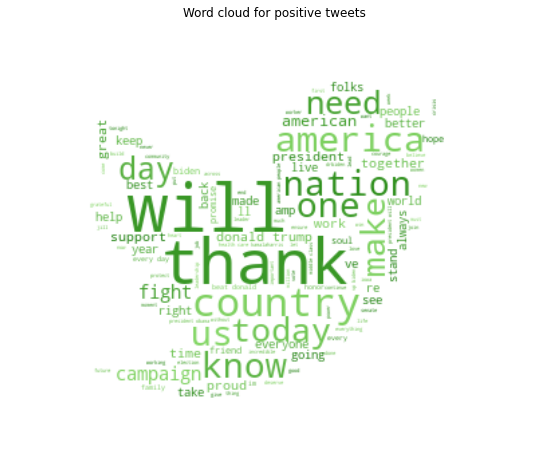

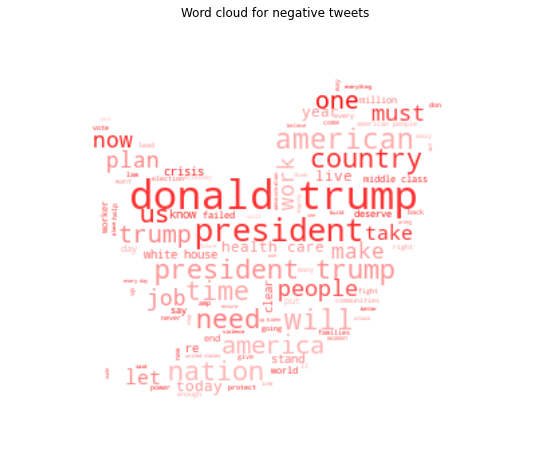

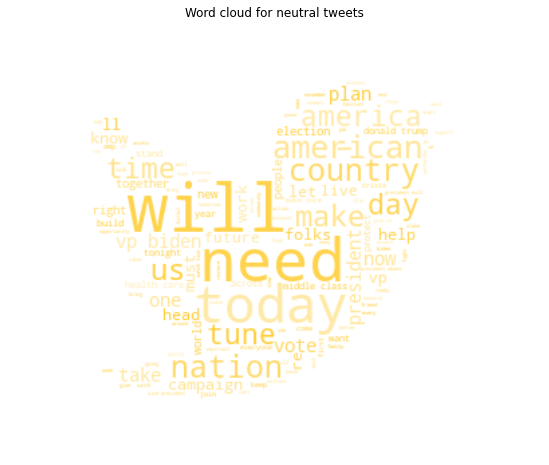

In [51]:
from matplotlib.colors import LinearSegmentedColormap
colors_pos = ["#88D969", "#1D800E"]
cmap_pos = LinearSegmentedColormap.from_list("mycmapos", colors_pos)

colors_neg = ["#ffbaba", "#ff0000"]
cmap_neg = LinearSegmentedColormap.from_list("mycmapos", colors_neg)

colors_neutral = ["#ffecb3", "#ffca28"]
cmap_neutral = LinearSegmentedColormap.from_list("mycmapos", colors_neutral)




plot_word_cloud(df_joe_positive, cmap_pos, 'positive')
plot_word_cloud(df_joe_negative, cmap_neg, 'negative')
plot_word_cloud(df_joe_neutral, cmap_neutral, 'neutral')

<h1 style="text-align:center; background-color:#D8E46B">Future Work</h1>

1. I still need to employ BERT large model to test its accuracy on GitHub message classification use-case.
2. The dataset provided has rich textual information. This can be leveraged for other NLP tasks such as natural language generation.

<h1 style="text-align:center; background-color:#D8E46B">References</h1>

1. https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/
2. https://huggingface.co/transformers/
3. http://jalammar.github.io
4. Word cloud reference : https://www.kaggle.com/ihelon/ukrainian-descriptions-word-cloud-tutorial